In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (K*8*(N-1)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def hs(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return ((2*i+2*j-h)**2)/h

def SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    d = np.zeros(2)
    N = np.zeros(10)
    
    for k in range(10):
        N[k] = n[k]
    
    if T < cc:
        while T < cc:
            if N[4] > 0: N[4] -= 1
            elif N[1] > 0: N[1] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            elif N[2] > 0: N[2] -= 1
            else: N[3] -= 1
            N[9] += 1
            
            T = hs(N)
            d[0] -= 1
        
        T = hs(n)
        for k in range(10):
            N[k] = n[k]
        
        while T < cc:
            if N[6] > 0: N[6] -= 1
            elif N[8] > 0: N[8] -= 1
            elif N[9] > 0: N[9] -= 1
            elif N[2] > 0: N[2] -= 1
            elif N[3] > 0: N[3] -= 1
            elif N[5] > 0: N[5] -= 1
            elif N[7] > 0: N[7] -= 1
            elif N[0] > 0: N[0] -= 1
            else: N[1] -= 1
            N[4] += 1
            
            T = hs(N)
            d[1] -= 1
        
        if d[0] > d[1]:
            return d[0]
        else:
            return d[1]
        
    else:
        step = 0
        
        for k in range(10):
            N[k] = n[k]
            
        if i+j > h/2:
            while T >= cc:
                if N[6] > 0: N[6] -= 1
                elif N[8] > 0: N[8] -= 1
                elif N[9] > 0: N[9] -= 1
                elif N[2] > 0: N[2] -= 1
                elif N[3] > 0: N[3] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                else: N[1] -= 1
                N[4] += 1
                
                T = hs(N)
                step += 1
        else:
            while T >= cc:
                if N[4] > 0: N[4] -= 1
                elif N[1] > 0: N[1] -= 1
                elif N[0] > 0: N[0] -= 1
                elif N[5] > 0: N[5] -= 1
                elif N[7] > 0: N[7] -= 1
                elif N[2] > 0: N[2] -= 1
                else: N[3] -= 1
                N[9] += 1
                
                T = hs(N)
                step += 1
                
        return step-1

In [4]:
def appx_SHD_hs(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = hs(n)
    
    if T < cc:
        if i+j >= h/2:
            if h <= cc:
                return -math.ceil((cc-(i+j))/2)
            else:
                return -math.ceil(((h+math.sqrt(h*cc))/2 - (i+j))/2)
        else:
            if h <= cc:
                return -math.ceil((cc-h+i+j)/2)
            else:
                return -math.ceil((i+j - (h-math.sqrt(h*cc))/2)/2)
    else:
        if i+j >= h/2:
            return math.ceil((i+j - (h+math.sqrt(h*cc))/2)/2) - 1
        else:
            return math.ceil(((h-math.sqrt(h*cc))/2 - (i+j))/2)-1

In [5]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

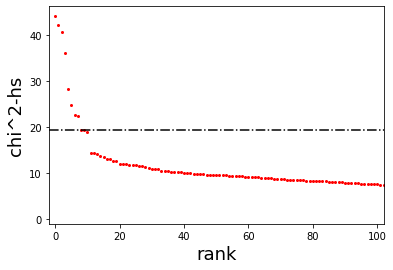

In [6]:
N = 150
M = 5000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    n[i][4] = np.random.binomial(2*N, 1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]
    
for i in range(M-10,M):
    n[i][4] = np.random.binomial(2*N, 1.5/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    n[i][6] = np.random.binomial(S, 1/3)
    n[i][8] = np.random.binomial(S-n[i][6], 1/3)
    n[i][9] = S-n[i][6]-n[i][8]
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1.5/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    n[i][0] = np.random.binomial(R, 1/3)
    n[i][5] = np.random.binomial(R-n[i][0], 1/2)
    n[i][7] = R - n[i][0] - n[i][5]
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = ((2*I[i] + 2*J[i] - H[i])**2)/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(19.5, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-hs", fontsize = 18)
fig.savefig("stats-hs-small.png")
fig.savefig("fig/stats-hs-small.eps")

In [7]:
cc = 19.5
appx_shd = np.zeros(M)
shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_hs(cc,k)
    shd[i] = SHD_hs(cc,k)

print(appx_shd)
print(shd)

[-12. -19. -22. ...  -1.  10.   1.]
[-12. -19. -22. ...  -1.  10.   1.]


In [8]:
def evaluation_Lap(data,epsilon, K, N, M):
    correct = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            if noisy_rank[i] <= K:
                correct += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

In [9]:
def evaluation_Exp(x, appx_shd, shd, epsilon, K, N, M):
    accuracy = np.zeros(2)
    correct = np.zeros(2)
    cc = 19.5
    
    true = np.zeros(K)
    for i in range(K):
        true[i] = x[M-1-i]
        
    APPX = np.zeros(M)
    SHD = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
            SHD[i] = shd[i]
        
        #print(APPX)
        #print(SHD)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        exact_result = exp_mec(SHD, M, K, epsilon)
        #print(appx_result)
        #print(exact_result)
        for k in range(K):
            for l in range(K):
                if appx_result[k] == true[l]:
                    correct[0] += 1
                if exact_result[k] == true[l]:
                    correct[1] += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

[[0.   0.   0.  ]
 [0.   0.18 0.1 ]
 [0.04 0.38 0.3 ]
 [0.44 0.66 0.46]
 [0.6  0.52 0.84]
 [0.58 0.66 0.9 ]
 [0.78 0.86 0.82]]
[[0.   0.   0.  ]
 [0.   0.12 0.1 ]
 [0.04 0.36 0.3 ]
 [0.32 0.52 0.68]
 [0.62 0.62 0.6 ]
 [0.64 0.66 0.74]
 [0.82 0.84 0.8 ]]
[[0.   0.   0.  ]
 [0.   0.06 0.2 ]
 [0.06 0.44 0.4 ]
 [0.5  0.58 0.64]
 [0.54 0.74 0.6 ]
 [0.72 0.8  0.9 ]
 [0.82 0.84 0.88]]
[[0.   0.   0.  ]
 [0.   0.06 0.02]
 [0.1  0.36 0.42]
 [0.46 0.6  0.48]
 [0.62 0.76 0.54]
 [0.62 0.76 0.82]
 [0.66 0.88 0.86]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.   0.  ]
 [0.   0.06 0.08]
 [0.04 0.44 0.36]
 [0.46 0.62 0.56]
 [0.62 0.84 0.78]
 [0.64 0.74 0.74]
 [0.78 0.94 0.86]]


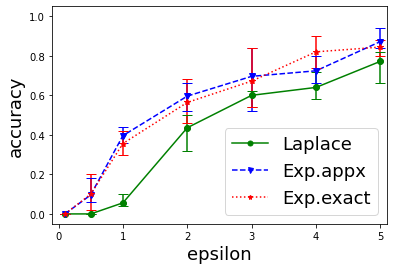

In [10]:
K = 1
N = 150
M = 5000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_small_K=1.png")
fig.savefig("fig/evaluation_hs_small_K=1.eps")

[[0.   0.   0.  ]
 [0.   0.   0.01]
 [0.   0.14 0.21]
 [0.07 0.63 0.63]
 [0.38 0.65 0.62]
 [0.64 0.64 0.7 ]
 [0.79 0.73 0.74]]
[[0.   0.   0.  ]
 [0.   0.01 0.01]
 [0.01 0.19 0.15]
 [0.05 0.61 0.59]
 [0.42 0.76 0.7 ]
 [0.66 0.63 0.76]
 [0.7  0.67 0.75]]
[[0.   0.   0.  ]
 [0.   0.03 0.02]
 [0.   0.2  0.23]
 [0.12 0.6  0.66]
 [0.39 0.62 0.64]
 [0.68 0.68 0.76]
 [0.72 0.71 0.75]]
[[0.   0.   0.  ]
 [0.   0.   0.01]
 [0.   0.11 0.18]
 [0.1  0.57 0.62]
 [0.52 0.72 0.65]
 [0.68 0.7  0.69]
 [0.73 0.76 0.67]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.   0.  ]
 [0.   0.04 0.  ]
 [0.   0.12 0.15]
 [0.13 0.61 0.61]
 [0.47 0.67 0.65]
 [0.73 0.65 0.73]
 [0.73 0.72 0.7 ]]


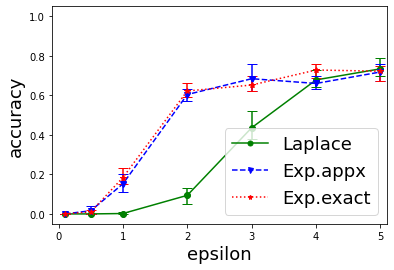

In [11]:
K = 2
N = 150
M = 5000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_small_K=2.png")
fig.savefig("fig/evaluation_hs_small_K=2.eps")

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.08       0.07333333]
 [0.         0.56       0.61333333]
 [0.08666667 0.82       0.74666667]
 [0.41333333 0.87333333 0.89333333]
 [0.66       0.92       0.92666667]]
[[0.         0.         0.00666667]
 [0.         0.         0.00666667]
 [0.         0.04666667 0.06666667]
 [0.02666667 0.56       0.62666667]
 [0.07333333 0.84       0.85333333]
 [0.36666667 0.86       0.84666667]
 [0.65333333 0.91333333 0.89333333]]
[[0.00666667 0.         0.        ]
 [0.00666667 0.         0.00666667]
 [0.00666667 0.06       0.07333333]
 [0.02       0.62       0.6       ]
 [0.10666667 0.8        0.83333333]
 [0.34666667 0.90666667 0.88      ]
 [0.65333333 0.92       0.87333333]]
[[0.         0.         0.        ]
 [0.         0.01333333 0.01333333]
 [0.         0.03333333 0.04      ]
 [0.00666667 0.51333333 0.57333333]
 [0.08666667 0.74       0.81333333]
 [0.36666667 0.84       0.88666667]
 [0.67333333 0.93333333 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.         0.        ]
 [0.00666667 0.00666667 0.00666667]
 [0.00666667 0.05333333 0.04      ]
 [0.00666667 0.58       0.66666667]
 [0.12       0.78       0.82      ]
 [0.38666667 0.86666667 0.91333333]
 [0.67333333 0.92       0.92666667]]


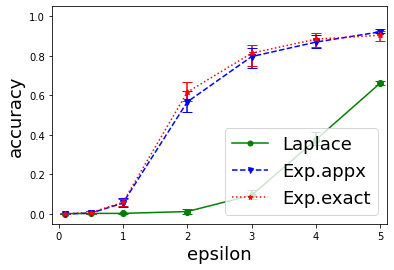

In [12]:
K = 3
N = 150
M = 5000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_small_K=3.png")
fig.savefig("fig/evaluation_hs_small_K=3.eps")

[[0.    0.    0.   ]
 [0.    0.004 0.   ]
 [0.    0.028 0.008]
 [0.008 0.152 0.128]
 [0.012 0.512 0.512]
 [0.056 0.78  0.736]
 [0.088 0.872 0.856]]
[[0.004 0.004 0.   ]
 [0.    0.008 0.   ]
 [0.    0.012 0.02 ]
 [0.008 0.18  0.148]
 [0.02  0.52  0.524]
 [0.044 0.808 0.788]
 [0.108 0.844 0.832]]
[[0.004 0.004 0.   ]
 [0.004 0.004 0.   ]
 [0.    0.024 0.02 ]
 [0.02  0.164 0.152]
 [0.012 0.552 0.5  ]
 [0.048 0.78  0.776]
 [0.104 0.856 0.856]]
[[0.    0.004 0.   ]
 [0.004 0.    0.004]
 [0.008 0.028 0.012]
 [0.008 0.144 0.148]
 [0.012 0.54  0.52 ]
 [0.056 0.772 0.756]
 [0.1   0.86  0.844]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.    0.    0.004]
 [0.004 0.008 0.004]
 [0.    0.012 0.012]
 [0.008 0.16  0.144]
 [0.004 0.584 0.544]
 [0.044 0.772 0.776]
 [0.084 0.88  0.876]]


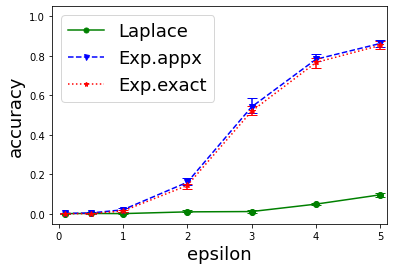

In [13]:
K = 5
N = 150
M = 5000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_small_K=5.png")
fig.savefig("fig/evaluation_hs_small_K=5.eps")

[[0.008 0.004 0.002]
 [0.006 0.    0.006]
 [0.004 0.004 0.006]
 [0.002 0.022 0.026]
 [0.006 0.056 0.048]
 [0.008 0.16  0.164]
 [0.012 0.302 0.308]]
[[0.002 0.006 0.004]
 [0.004 0.002 0.002]
 [0.004 0.004 0.006]
 [0.002 0.022 0.022]
 [0.006 0.058 0.064]
 [0.004 0.18  0.19 ]
 [0.028 0.338 0.332]]
[[0.002 0.002 0.002]
 [0.002 0.004 0.006]
 [0.002 0.012 0.006]
 [0.    0.022 0.016]
 [0.008 0.048 0.048]
 [0.012 0.174 0.174]
 [0.008 0.304 0.342]]
[[0.002 0.002 0.   ]
 [0.    0.002 0.004]
 [0.006 0.004 0.004]
 [0.006 0.016 0.02 ]
 [0.006 0.064 0.06 ]
 [0.012 0.146 0.162]
 [0.022 0.322 0.322]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.004 0.004 0.004]
 [0.002 0.004 0.004]
 [0.004 0.006 0.004]
 [0.002 0.02  0.028]
 [0.006 0.07  0.08 ]
 [0.01  0.184 0.152]
 [0.012 0.324 0.346]]


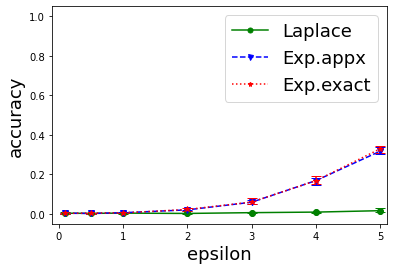

In [14]:
K = 10
N = 150
M = 5000

accuracy = np.zeros((7,3))
max_acc = np.zeros((7,3))
min_acc = np.ones((7,3))
sum_acc = np.zeros((7,3))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        temp = evaluation_Exp(x, appx_shd, shd, epsilon[i],K,N,M)
        accuracy[i][1] = temp[0]
        accuracy[i][2] = temp[1]
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        if accuracy[i][2] > max_acc[i][2]:
            max_acc[i][2] = accuracy[i][2]
        if accuracy[i][2] < min_acc[i][2]:
            min_acc[i][2] = accuracy[i][2]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
        sum_acc[i][2] += accuracy[i][2]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,3))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]
y_err[0,:,2] = accuracy[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - accuracy[:,2]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.errorbar(epsilon, accuracy[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, accuracy[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Exp.exact")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_hs_small_K=10.png")
fig.savefig("fig/evaluation_hs_small_K=10.eps")